# How to use the Irspec2d script

The test data is in the `testdata` folder.  
It's for the DAR molecule calculated with a def2-TZVP basis set and the b3-lyp functional.  
The hetero-hydrogen atoms were deuterated and its calculated in D2O using COSMO.

In [1]:
import sys
sys.path.append('/home/julia/2d-ir-spectroscopy/src')
sys.path.append('/home/julia/2d-ir-spectroscopy/src/Irspec2d/')

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap

colors = ["#70002d","#b00046", "#c0336b", "#ffffff", "#3399c3", "#005374", "#00364c"]
ccmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
ccmap1_r = LinearSegmentedColormap.from_list("mycmap", colors[::-1])

from Irspec2d import * 

In [2]:
# load data

VCI_freq = np.load('testdata/VCI_frequencies.npy')
VCI_dipo = np.load('testdata/VCI_dipolemoments.npy')
VCI_ints = np.load('testdata/VCI_intensities.npy')

VCI_freq_h = np.load('testdata/VCI_frequencies_harm.npy')
VCI_dipo_h = np.load('testdata/VCI_dipolemoments_harm.npy')
VCI_ints_h = np.load('testdata/VCI_intensities_harm.npy')

EXC_cmat = np.load('testdata/Exciton_cmat_lm.npy')
EXC_dipo = np.load('testdata/Exciton_dipolemoments_lm.npy')

-----------------
## 1D Spectra

In order to plot 1D spectra I added a few (static) methods to the spectra class.

```python
def get_norm_spectrum(xmin,xmax,freqs,ints,steps=5000,halfwidth=5,ftype='gauss'):
    (...)
    return x,y
```

This computes the x and y values for the spectra. One can chose between gaussian and lorentzian functions.

If the intensities are not given, one can use 
```python
def calc_trans2int():
    (...)
    return intenmat
```
from the Calc2dir_base class in order to calculate the intensity matrix from the given transition dipole moment matrix.  
Use it like this:
```python
calc_ints = Calc2dir_base(freqs, dips).calc_trans2int()
```

In [3]:
x_1d_g,y_1d_g = spectra.get_norm_1d_spectrum(2000,2200,VCI_freq[0],VCI_ints[0],ftype='gauss')
x_1d_l,y_1d_l = spectra.get_norm_1d_spectrum(2000,2200,VCI_freq[0],VCI_ints[0],ftype='lorentz')

x_1d_g_h,y_1d_g_h = spectra.get_norm_1d_spectrum(2000,2200,VCI_freq_h[0],VCI_ints_h[0],ftype='gauss')
x_1d_l_h,y_1d_l_h = spectra.get_norm_1d_spectrum(2000,2200,VCI_freq_h[0],VCI_ints_h[0],ftype='lorentz')

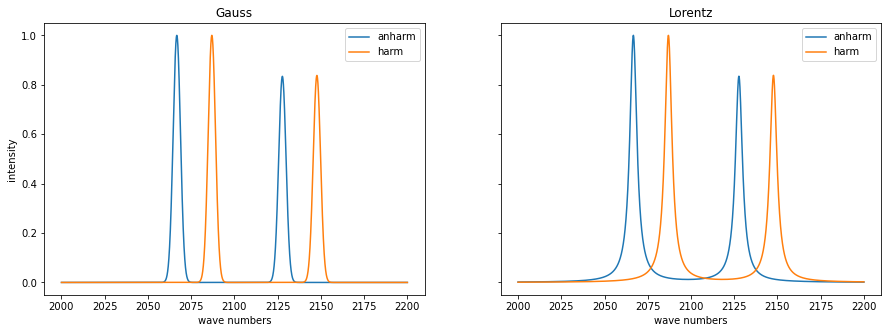

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

ax1.plot(x_1d_g, y_1d_g,label='anharm')
ax2.plot(x_1d_l, y_1d_l,label='anharm')

ax1.plot(x_1d_g_h, y_1d_g_h,label='harm')
ax2.plot(x_1d_l_h, y_1d_l_h,label='harm')

ax1.set_title('Gauss')
ax2.set_title('Lorentz')

ax1.set_ylabel('intensity')
ax1.set_xlabel('wave numbers')
ax2.set_xlabel('wave numbers')

ax1.legend()
ax2.legend()

plt.show()

-------------------
## Frequency Domain

There are three processes that can happen: Excited State Absorption, Stimulated Emission and Ground State Bleach.  
Each of them can be calculated by a function as tuples:
```python
def calc_excitation(self,intmat):
    (...)
    return (exc_x, exc_y, exc_i)

def calc_stimulatedemission(self,intmat):
    (...)
    return (emi_x, emi_y, emi_i)

def calc_bleaching(self,intmat):
    (...)
    return (ble_x, ble_y, ble_i)
```
In order to compute all of them at once, there is
```python
def calc_all_2d_process(self):
    (...)
    return exc, ste, ble
```

This leads to x- and y-coordinates of the differnt peaks with their respective intensities.  

In [5]:
exc,emi,ble = freqdomain(VCI_freq,VCI_dipo).calc_all_2d_process()

Now, there are functions fittet on top of these peaks - analogous to the 1D spectra seen before one can chose between gauss and lorentz functions.  
They can also be normalized, so that the highest peak has the intensity = 1.
```python
def get_2d_spectrum(xmin,xmax,exc,ble,emi,steps=2000,halfwidth=15,ftype='gauss'):
    (...)
    return x,y,z

def norm_2d_spectum(z,max_z):
    (...)
    return z
```

In [6]:
dim = 1000
min_fd = 2035
max_fd = 2150

x_2d_g,y_2d_g,z_2d_g = spectra.get_2d_spectrum(min_fd,max_fd,exc,ble,emi,steps=500,ftype='gauss')
z_2d_g = spectra.norm_2d_spectrum(z_2d_g,np.asarray(z_2d_g).max())

x_2d_l,y_2d_l,z_2d_l = spectra.get_2d_spectrum(min_fd,max_fd,exc,ble,emi,steps=500,ftype='lorentz')
z_2d_l = spectra.norm_2d_spectrum(z_2d_l,np.asarray(z_2d_l).max())

In order to plot the lines beautifully, another function
```python
def set_line_spacing(maximum,number):
```
is used. This takes in the maximum value of an array and the number of contour lines one would like to have.

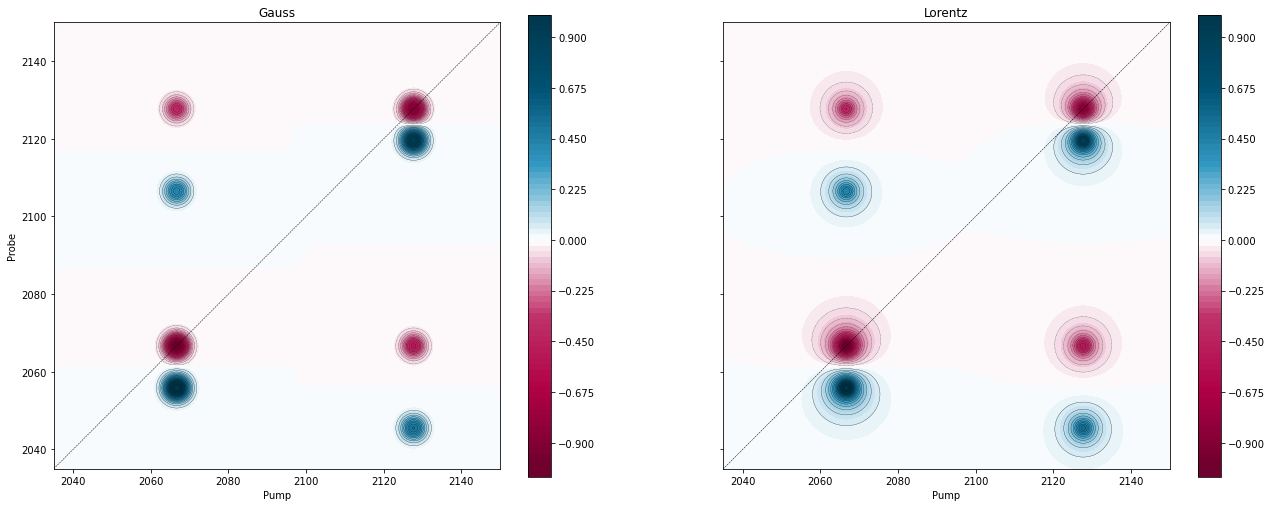

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,10))

ax1.plot([min_fd,max_fd], [min_fd,max_fd], ls="--", c="0", linewidth=0.5)
ax2.plot([min_fd,max_fd], [min_fd,max_fd], ls="--", c="0", linewidth=0.5)

im1 = ax1.contourf(x_2d_g,y_2d_g,z_2d_g, 100, alpha=1, cmap=ccmap1, vmax=1, vmin=-1)
im2 = ax2.contourf(x_2d_l,y_2d_l,z_2d_l, 100, alpha=1, cmap=ccmap1, vmax=1, vmin=-1)

ax1.contour(x_2d_g,y_2d_g,z_2d_g,spectra.set_line_spacing(abs(np.asarray(z_2d_g).max()),20),colors='k',linewidths=.25)
ax2.contour(x_2d_l,y_2d_l,z_2d_l,spectra.set_line_spacing(abs(np.asarray(z_2d_l).max()),20),colors='k',linewidths=.25)

ax1.set_title('Gauss')
ax2.set_title('Lorentz')

ax1.set_ylabel('Probe')
ax1.set_xlabel('Pump')
ax2.set_xlabel('Pump')

ax1.set_aspect(1./ax1.get_data_ratio())
ax2.set_aspect(1./ax2.get_data_ratio())

fig.colorbar(im1, ax=ax1, shrink=0.85)
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()

----------
## Time Domain

The time domain calculation needs more parameters:
- $n_t$ (n_t) : number of time points (grid)
- $\Delta t$ (dt) : spacing between time points
- $T_2$ (T2) : dephasing time
- $t2$ (t2) : time between laser pulses
- pol : polarization condition, e.g. 'ZZZZ' or 'ZZXX'
- pol_list : polarization condition angles, e.g. [0,0,0,0] or [0,0,90,90]
- omega_off : roughly the median of fundamental frequencies

If none are given, the calculation automatically choses standard values.

```python
timedomain(VCI_freq,VCI_dipo,n_t=n_t,dt=dt,T2=T2,pol=pol,pol_list=pol_list,omega_off=omega_off)
```

All calculations can also be done for the harmonic spectra! 

In [8]:
R, ticks = timedomain(VCI_freq,VCI_dipo).get_absorptive_spectrum()
R = spectra.norm_2d_spectrum(R,R.max())

Rh, ticksh = timedomain(VCI_freq_h,VCI_dipo_h).get_absorptive_spectrum()
Rh = spectra.norm_2d_spectrum(Rh,R.max())

Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).
Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).
Set the omega offset value (omega_off) to 2117 (calculated default).


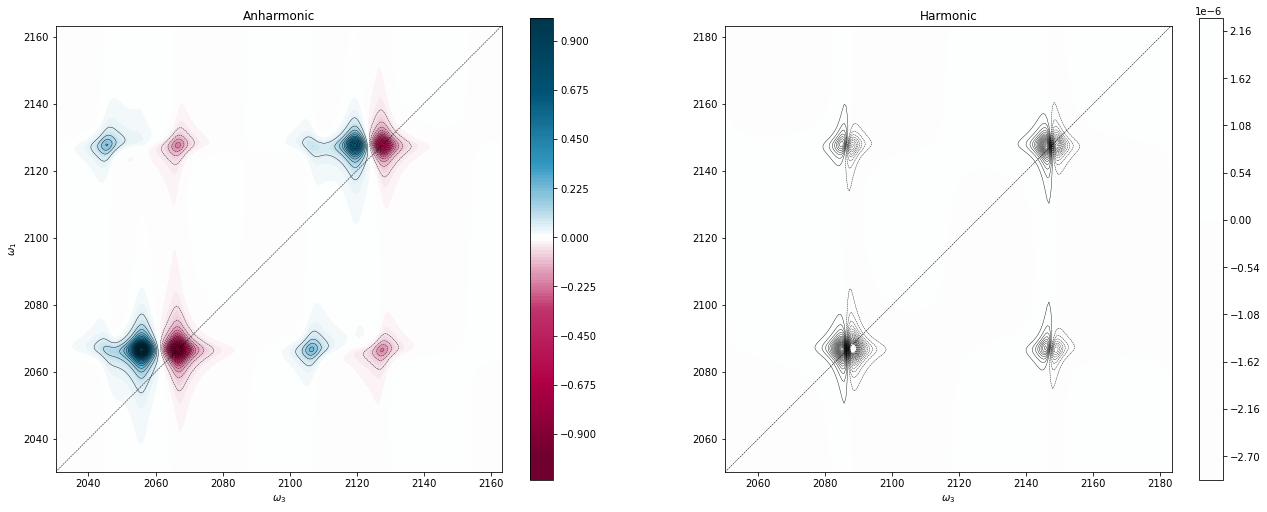

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

ax1.plot([min(ticks),max(ticks)], [min(ticks),max(ticks)], ls="--", c="0", linewidth=0.5)
ax2.plot([min(ticksh),max(ticksh)], [min(ticksh),max(ticksh)], ls="--", c="0", linewidth=0.5)

im1 = ax1.contourf(ticks, ticks, R, 200, alpha=1, cmap=ccmap1, vmax=abs(R.max()), vmin=-abs(R.max()))
im2 = ax2.contourf(ticksh, ticksh, Rh, 200, alpha=1, cmap=ccmap1, vmax=abs(R.max()), vmin=-abs(R.max()))

ax1.contour(ticks, ticks, R, spectra.set_line_spacing(abs(R.max()),20), colors='k', linewidths=.4)
ax2.contour(ticksh, ticksh, Rh, spectra.set_line_spacing(abs(Rh.max()),20), colors='k', linewidths=.4)

ax1.set_title('Anharmonic')
ax2.set_title('Harmonic')

ax1.set_ylabel('$\\omega_1$')
ax1.set_xlabel('$\\omega_3$')
ax2.set_xlabel('$\\omega_3$')

ax1.set_xlim(min(ticks),max(ticks))
ax2.set_xlim(min(ticksh),max(ticksh))

ax1.set_ylim(min(ticks),max(ticks))
ax2.set_ylim(min(ticksh),max(ticksh))

ax1.set_aspect(1./ax1.get_data_ratio())
ax2.set_aspect(1./ax2.get_data_ratio())

fig.colorbar(im1, ax=ax1, shrink=0.85)
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()

------------
## Exciton Model 

The exciton model is used to compute the frequency matrix and the transition dipole moment matrix from harmonic calculations using an empirical parameter for the anharmonicity. 

In [10]:
EX_freqs, EX_dipoles = excitonmodel(EXC_cmat, EXC_dipo).get_nm_freqs_dipolmat(20)

In [11]:
# Use this in order to calculate intensities for the exciton model :
# EXC_ints = Calc2dir_base(EX_freqs, EX_dipoles).calc_trans2int()

In [12]:
R_EX, ticks_EX = timedomain(EX_freqs,EX_dipoles).get_absorptive_spectrum()
R_EX = spectra.norm_2d_spectrum(R_EX,R_EX.max())

excEX,bleEX,emiEX = freqdomain(EX_freqs, EX_dipoles).calc_all_2d_process()

min_EX = min(ticks_EX)
max_EX = max(ticks_EX)
x_EX_l,y_EX_l,z_EX_l_ = spectra.get_2d_spectrum(min_EX,max_EX,excEX,bleEX,emiEX,steps=500,ftype='lorentz')
z_EX_l = spectra.norm_2d_spectrum(z_EX_l_,np.asarray(z_EX_l_).max())

Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).


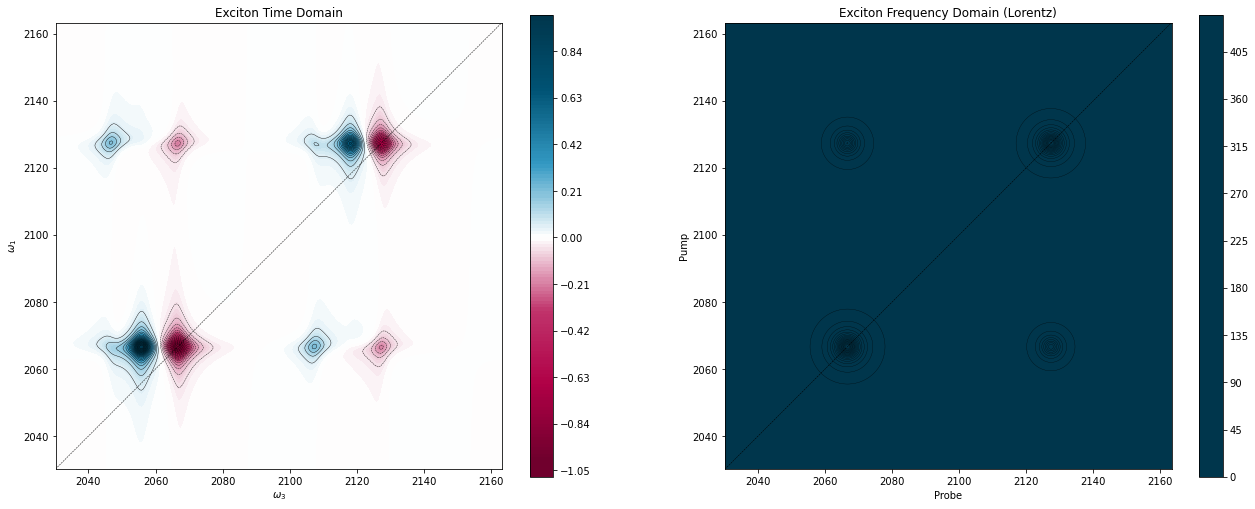

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

ax1.plot([min(ticks_EX),max(ticks_EX)], [min(ticks_EX),max(ticks_EX)], ls="--", c="0", linewidth=0.5)
im1 = ax1.contourf(ticks_EX, ticks_EX, R_EX, 200, alpha=1, cmap=ccmap1, vmax=abs(R_EX.max()), vmin=-abs(R_EX.max()))
ax1.contour(ticks_EX, ticks_EX, R_EX, spectra.set_line_spacing(abs(R_EX.max()),20), colors='k', linewidths=.4)

ax1.set_title('Exciton Time Domain')
ax1.set_ylabel('$\\omega_1$')
ax1.set_xlabel('$\\omega_3$')
ax1.set_xlim(min(ticks_EX),max(ticks_EX))
ax1.set_ylim(min(ticks_EX),max(ticks_EX))
ax1.set_aspect(1./ax1.get_data_ratio())
fig.colorbar(im1, ax=ax1, shrink=0.85)


ax2.set_title('Exciton Frequency Domain (Lorentz)')
ax2.plot([min_EX,max_EX], [min_EX,max_EX], ls="--", c="0", linewidth=0.5)
im2 = ax2.contourf(x_EX_l,y_EX_l,np.asarray(z_EX_l).T, 100, alpha=1, cmap=ccmap1, vmax=1, vmin=-1)
ax2.contour(x_EX_l,y_EX_l,np.asarray(z_EX_l).T,spectra.set_line_spacing(abs(np.asarray(z_EX_l).max()),20),colors='k',linewidths=.25)
ax2.set_ylabel('Pump')
ax2.set_xlabel('Probe')
ax2.set_xlim(min_EX,max_EX)
ax2.set_ylim(min_EX,max_EX)
ax2.set_aspect(1./ax2.get_data_ratio())
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()